# Extracting field data from hand-filled forms: prototyping extraction pipeline

RE Sources has been monitoring the quality of stormwater outfalls in the Salish Sea for a few years, and they have a somewhat labor-intensive data entry process that Cascade STEAM has offered to automate. I'm volunteering to work on this project, in collaboration with Kris Keillor, and this notebook serves as a WIP proof of concept for extracting data from stormwater monitoring field datasheets.

Currently, data collectors in the field handwrite observations in a printed PDF, and then periodically someone manually enters these observations into the database. It takes quite a bit of time to do, so they batch it out, and so it can be a while before it gets done, costing volunteer and paid hours along with creating a lag in the availability of research data for analysis and reporting.

Ultimately, we might like to create a mobile app for data collectors to enter observations into directly. But, for now, we've decided to start with their existing habits and build something smaller and perhaps more managable. So, we are working on a tool to apply optical character recognition (OCR) to read the hand-filled forms and extract the observations. This allows the users to continue to use pen and paper while shortening the time and labor needed to enter the data from the froms into the database.

## Pipeline overview

At a high level, we need to:

1. Create a template of the form, including locating fiducial points and text fields (regions of interest, or ROIs) that we can reliably find on the filled-out input forms.
2. Transform the input forms to align them to the template based on their fiducial points, applying image preprocessing as needed to clarify the fiducial points.
3. Break down the transformed input images into their ROIs using the template's ROI coordinates.
4. Apply OCR to read the handwritten text into a datastructure, applying image preprocessing as needed to clarify the handwritten text.

## Create template, with fiducal points.

### Create template image.

To create a crisp template image, we're turning the PDF into an image, avoiding problems with photographing a paper template. We use PyMuPDF's `fitz` package to rasterize the PDF into an image.

In [ ]:
import numpy as np
import cv2 # OpenCV
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Any

from pprint import pp
from IPython.display import Image
# Allows all output from a cell to display, instead of just the last one.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [ ]:
# TODO: Use PDF without fillable fields for fiducial detection because the watermarks obscure the corners.
TEMPLATE_PATH = Path("Field-Datasheet-Current-ver-4.4-1-29-2025_FORM_FILLABLE.pdf")
SCANNED_PDF_PATH = Path("images/ideal_form_scanned_600_DPI_color.pdf")
TEMPLATE_DPI = 600
SCANNED_DPI = 600

In [3]:
template_doc = fitz.open(TEMPLATE_PATH)
template_page = template_doc[0]

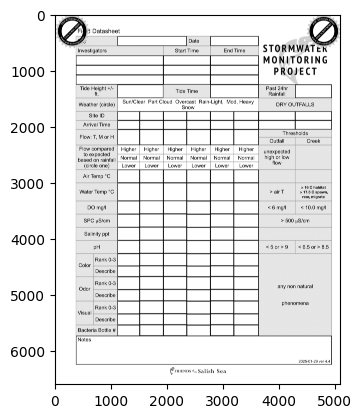

In [ ]:
def rasterize_PDF_to_image(
    page: fitz.Page,
    dpi: int
) -> cv2.Mat | np.ndarray[Any, np.dtype[np.integer[Any] | np.floating[Any]]]:
"""Rasterizes a PDF page to an image at the specified DPI.

    Args:
        page: The PDF page to rasterize.
        dpi: The desired DPI for the output image.

    Returns:
        The rasterized image as an OpenCV matrix (Numpy array).
    """
    scale = dpi / 72  # PDF “points” are 1/72 inch
    mat  = fitz.Matrix(scale, scale)
    pix = page.get_pixmap(matrix=mat)
    img_arr = np.frombuffer(pix.samples, dtype=np.uint8).reshape((pix.h, pix.w, pix.n))
    if pix.n == 4:  # Drop alpha channel if present.
        img_arr = img_arr[:, :, :3]

    img_gray = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)

    return img_gray


template_gray = rasterize_PDF_to_image(page=template_page, dpi=TEMPLATE_DPI)

plt.imshow(template_gray, cmap='gray')


### Find template fiducials.

We need to find three, well-spaced, noncolinear points on the template that we can reliably find on input images. We'll use these to apply an affine transformation to the input images' pixel matrices. (NOTE: We'd need to find four points and apply a homographic transform if we took photos of the input images, but we're scanning the images instead of taking photos, so it reduces the problem space to fewer dimensions to transform along, as well as removing the problem of background surface noise.)

TODO: We use ... ?

In [ ]:
# TODO: This isn't working (maybe because of watermarks?). Try again without watermarks, and try other methods outlined in Asana.
def get_fiducial_points(
    img: cv2.Mat | np.ndarray[Any, np.dtype[np.integer[Any] | np.floating[Any]]]
) -> np.ndarray[tuple[int, int], np.dtype[np.float32]]:
    """Detect fiducial points in the image.
    
    Args:
        img: The input image in grayscale.
        
    Returns:
        An array of detected fiducial points as (x, y) coordinates.
    """
    _, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)
    img_thresh = cv2.medianBlur(img_thresh, 3)
    contours, _ = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    print(f"Image shape: {img.shape}")

    border_corners = []
    for contour in contours:
        peri   = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            area = w * h
            print(f"area: {area}")
            # Adjust these area thresholds to match the printed mark size at 300 DPI
            # if 500 < area < 5000:
            print(f"x: {x}, y: {y}, w: {w}, h: {h}, area: {area}")
            print (f"w/h: {w/h}")
            # if 0.8 < w/h < 1.2:
            M = cv2.moments(approx)
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            breakpoint()
            border_corners.append([cx, cy])


template_fiducial_points = get_fiducial_points(img=template_gray)
print(f"Template fiducial points: {template_fiducial_points}")

Image shape: (6600, 5100)
area: 3591
x: 4569, y: 751, w: 27, h: 133, area: 3591
w/h: 0.20300751879699247
area: 4154
x: 4128, y: 751, w: 31, h: 134, area: 4154
w/h: 0.23134328358208955
area: 432
x: 654, y: 636, w: 9, h: 48, area: 432
w/h: 0.1875
area: 660
x: 411, y: 618, w: 10, h: 66, area: 660
w/h: 0.15151515151515152
area: 26
x: 4704, y: 572, w: 13, h: 2, area: 26
w/h: 6.5
Template fiducial points: None



### Find template ROIs.

We need to define the ROI bounding boxes so we can reliably find them in the input images once they're aligned.

#### Find template PDF's fields coordinates.

We're using `fitz` to locate the fillable fields as "widgets".

In [7]:
widgets = template_page.widgets()

#### Convert PDF coordinates to pixel coordinates.

Since the coordinates are in PDF coordinates, we scale them to the image to convert them to pixel coordinates so we can find them in the images.

In [ ]:
def convert_fitz_rect_to_pixel_rect(
    fitz_rect: fitz.Rect,
    fitz_page: fitz.Page,
    image_shape: np.ndarray[tuple[int, int], np.dtype[np.uint8]]
) -> tuple[int, int, int, int]:
    """Convert a PyMuPDF Rect to pixel coordinates in a cv2 image.
    
    Args:
        fitz_rect: The PyMuPDF Rect to convert.
        fitz_page: The PyMuPDF Page containing the Rect.
        image_shape: The shape of the image as a Numpy array.

    Returns:
        A tuple of pixel coordinates (x0, y0, x1, y1) corresponding to the Rect.
    """
    width_scale = image_shape.shape[1] / fitz_page.rect.width
    height_scale = image_shape.shape[0] / fitz_page.rect.height

    x0 = int(np.round(fitz_rect.x0 * width_scale))
    y0 = int(np.round(fitz_rect.y0 * height_scale))
    x1 = int(np.round(fitz_rect.x1 * width_scale))
    y1 = int(np.round(fitz_rect.y1 * height_scale))

    return (x0, y0, x1, y1)


ROIs = {}
for widget in widgets:
    field_rect = convert_fitz_rect_to_pixel_rect(
        fitz_rect=widget.rect,
        fitz_page=template_page,
        image_shape=template_gray
    )
    ROIs[widget.field_name] = {"template_rect": field_rect}

pp(ROIs)

{'City': {'template_rect': (1115, 397, 2350, 569)},
 'Date': {'template_rect': (2770, 397, 3632, 569)},
 'Investigators1': {'template_rect': (374, 742, 1931, 914)},
 'Investigators2': {'template_rect': (374, 914, 1931, 1087)},
 'Investigators3': {'template_rect': (374, 1087, 1931, 1260)},
 'StartTime1': {'template_rect': (1931, 742, 2770, 914)},
 'StartTime2': {'template_rect': (1931, 914, 2770, 1087)},
 'StartTime3': {'template_rect': (1931, 1087, 2770, 1260)},
 'EndTime1': {'template_rect': (2770, 742, 3632, 914)},
 'EndTime2': {'template_rect': (2770, 914, 3632, 1087)},
 'EndTime3': {'template_rect': (2770, 1087, 3632, 1260)},
 'TideHeight': {'template_rect': (1115, 1260, 1931, 1498)},
 'TideTime': {'template_rect': (2770, 1260, 3632, 1498)},
 'Rainfall': {'template_rect': (4283, 1260, 4935, 1498)},
 'SiteID1': {'template_rect': (1115, 1737, 1512, 1899)},
 'SiteID2': {'template_rect': (1512, 1737, 1931, 1899)},
 'SiteID3': {'template_rect': (1931, 1737, 2350, 1899)},
 'SiteID4': {'t

## Find input fiducials and align to template.

Next we find the same relative fiducial points on each input image that we found on the template, and we use those points to perform a transformation on the input image pixel matrix that aligns it with the template image. This allows us to, in the next step, use the template ROI coordinates to find the ROIs in the input images.

### Convert scanned input PDFs to images.

In the same way that we rasterized the template PDF into an image, we rasterize each scanned input PDF into an image.

We scan the forms ahead of time instead of taking a photo so the images are straight on and require a simpler transformation with fewer fiducial points to align them to the template, and because it mitigates the problems of variable lighting and backgrounds.

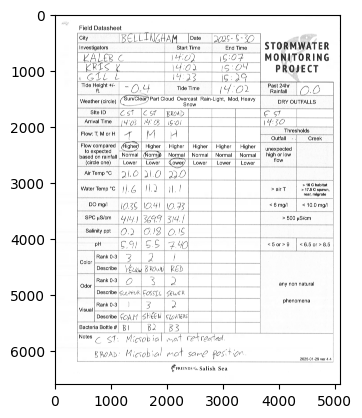

In [10]:
input_doc = fitz.open(SCANNED_PDF_PATH)
input_page = input_doc[0]

input_img_gray = rasterize_PDF_to_image(page=input_page, dpi=SCANNED_DPI)
plt.imshow(input_img_gray, cmap='gray')


### Find input fiducials.

Using the same process that we used to find the template fiducials (?), we find the fiducials of each input image.

In [11]:
input_img_fiducial_points = get_fiducial_points(img=input_img_gray)
print(f"Input image fiducial points: {input_img_fiducial_points}")

Image shape: (6600, 5100)
area: 9
x: 356, y: 4485, w: 3, h: 3, area: 9
w/h: 1.0
area: 4
x: 4192, y: 1059, w: 2, h: 2, area: 4
w/h: 1.0
area: 12
x: 4196, y: 1058, w: 4, h: 3, area: 12
w/h: 1.3333333333333333
area: 4
x: 4108, y: 1037, w: 2, h: 2, area: 4
w/h: 1.0
area: 9
x: 4155, y: 976, w: 3, h: 3, area: 9
w/h: 1.0
area: 4
x: 4276, y: 962, w: 2, h: 2, area: 4
w/h: 1.0
area: 4
x: 4155, y: 889, w: 2, h: 2, area: 4
w/h: 1.0
area: 6
x: 4178, y: 856, w: 3, h: 2, area: 6
w/h: 1.5
area: 12
x: 4195, y: 793, w: 4, h: 3, area: 12
w/h: 1.3333333333333333
area: 4
x: 4194, y: 768, w: 2, h: 2, area: 4
w/h: 1.0
area: 6
x: 4023, y: 762, w: 3, h: 2, area: 6
w/h: 1.5
area: 9
x: 4864, y: 734, w: 3, h: 3, area: 9
w/h: 1.0
area: 9
x: 4323, y: 725, w: 3, h: 3, area: 9
w/h: 1.0
area: 8
x: 4035, y: 696, w: 4, h: 2, area: 8
w/h: 2.0
area: 9
x: 4027, y: 683, w: 3, h: 3, area: 9
w/h: 1.0
area: 6
x: 4330, y: 676, w: 2, h: 3, area: 6
w/h: 0.6666666666666666
area: 9
x: 4100, y: 676, w: 3, h: 3, area: 9
w/h: 1.0
area

### Align input images to template.

Using an affine transformation provided by `cv2`, we plug in each image's fiducials along with the image and the template fiducials to transform each image to align with the template.

In [12]:
inpiut_img_fiducial_points = get_fiducial_points(img=input_img_gray)

M = cv2.getPerspectiveTransform(src=input_img_fiducial_points, dst=template_fiducial_points)
input_img_warped = cv2.warpPerspective(
    src=input_img_gray,
    M=M,
    dsize=(template_gray.shape[1], template_gray.shape[0])
)

plt.imshow(input_img_warped, cmap='gray')

Image shape: (6600, 5100)
area: 9
x: 356, y: 4485, w: 3, h: 3, area: 9
w/h: 1.0
area: 4
x: 4192, y: 1059, w: 2, h: 2, area: 4
w/h: 1.0
area: 12
x: 4196, y: 1058, w: 4, h: 3, area: 12
w/h: 1.3333333333333333
area: 4
x: 4108, y: 1037, w: 2, h: 2, area: 4
w/h: 1.0
area: 9
x: 4155, y: 976, w: 3, h: 3, area: 9
w/h: 1.0
area: 4
x: 4276, y: 962, w: 2, h: 2, area: 4
w/h: 1.0
area: 4
x: 4155, y: 889, w: 2, h: 2, area: 4
w/h: 1.0
area: 6
x: 4178, y: 856, w: 3, h: 2, area: 6
w/h: 1.5
area: 12
x: 4195, y: 793, w: 4, h: 3, area: 12
w/h: 1.3333333333333333
area: 4
x: 4194, y: 768, w: 2, h: 2, area: 4
w/h: 1.0
area: 6
x: 4023, y: 762, w: 3, h: 2, area: 6
w/h: 1.5
area: 9
x: 4864, y: 734, w: 3, h: 3, area: 9
w/h: 1.0
area: 9
x: 4323, y: 725, w: 3, h: 3, area: 9
w/h: 1.0
area: 8
x: 4035, y: 696, w: 4, h: 2, area: 8
w/h: 2.0
area: 9
x: 4027, y: 683, w: 3, h: 3, area: 9
w/h: 1.0
area: 6
x: 4330, y: 676, w: 2, h: 3, area: 6
w/h: 0.6666666666666666
area: 9
x: 4100, y: 676, w: 3, h: 3, area: 9
w/h: 1.0
area

error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:3623: error: (-215:Assertion failed) src.checkVector(2, CV_32F) == 4 && dst.checkVector(2, CV_32F) == 4 in function 'getPerspectiveTransform'



## Break down input image into ROI images.

Now we can pull out smaller images for each ROI in each input image, using the coordinates of each ROI established in the template.

In [13]:
for roi_field_name, template_rect in ROIs.items():
    x0, y0, x1, y1 = template_rect["template_rect"]
    roi = input_img_warped[y0:y1, x0:x1]
    ROIs[roi_field_name]["roi"] = roi

    roi_img = roi_data["roi"]
    cv2.imwrite(Path(f"scratch/roi_{roi_field_name}.jpg"), roi_img)

pp(ROIs)

NameError: name 'input_img_warped' is not defined

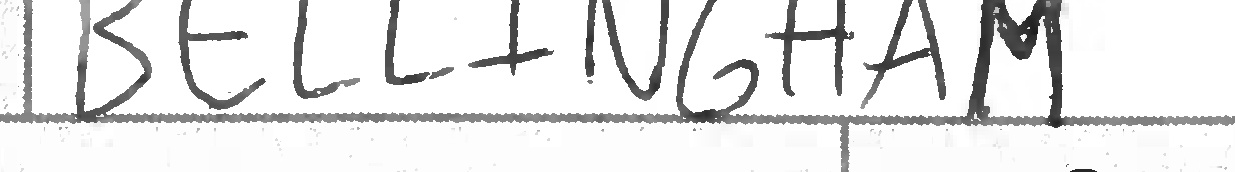

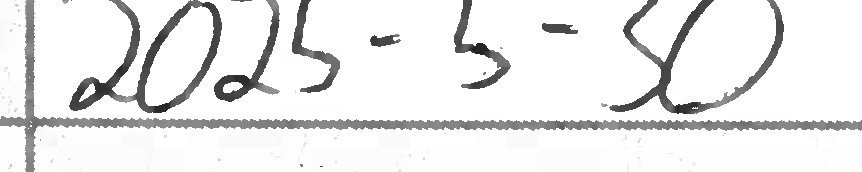

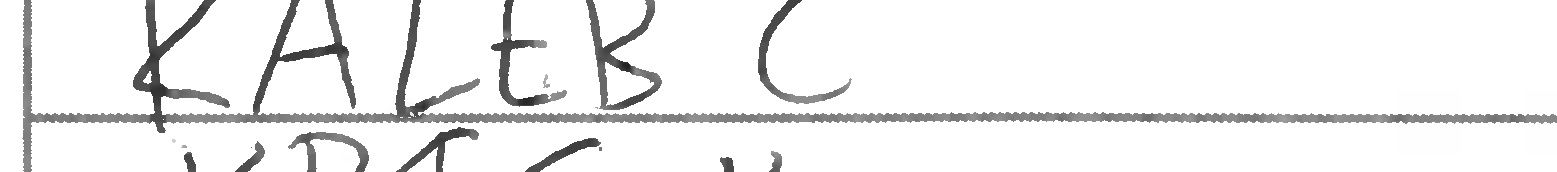

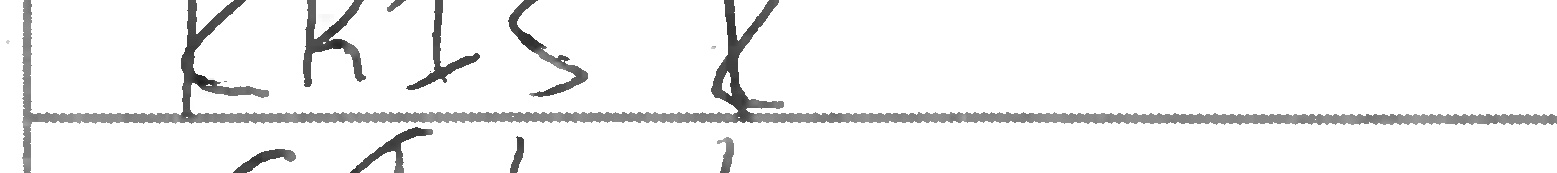

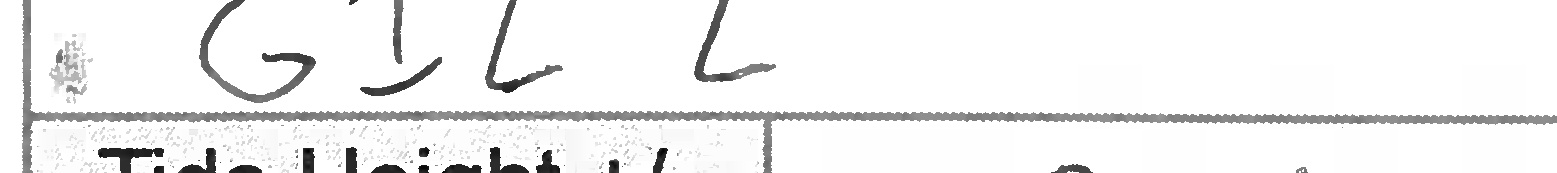

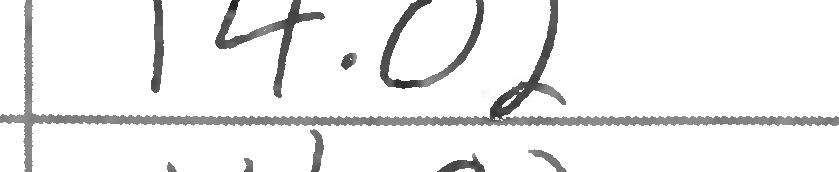

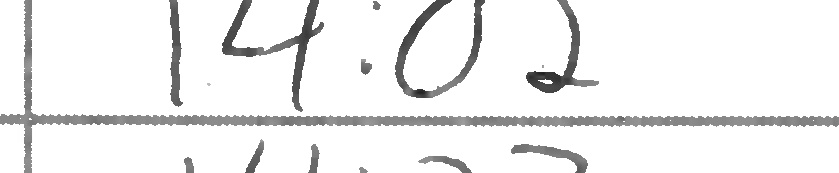

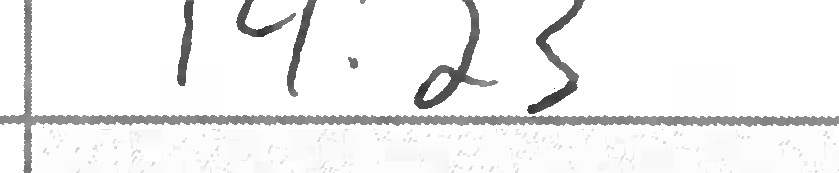

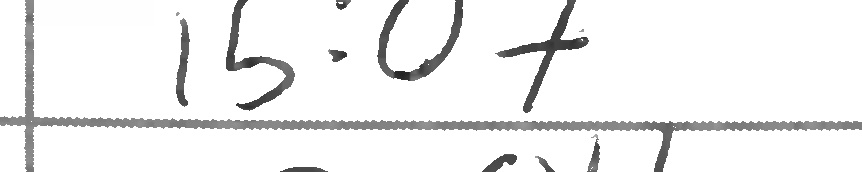

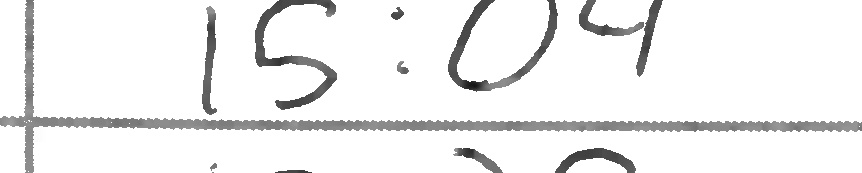

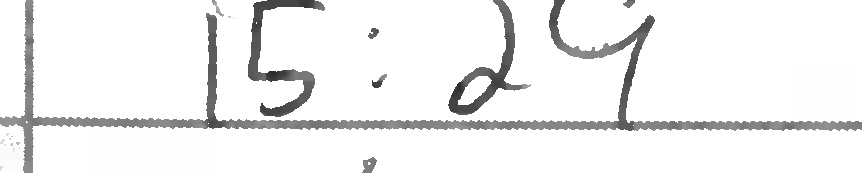

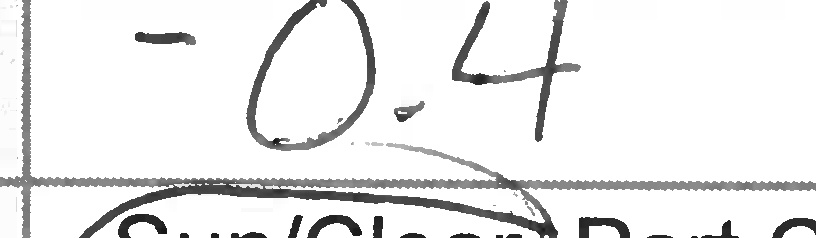

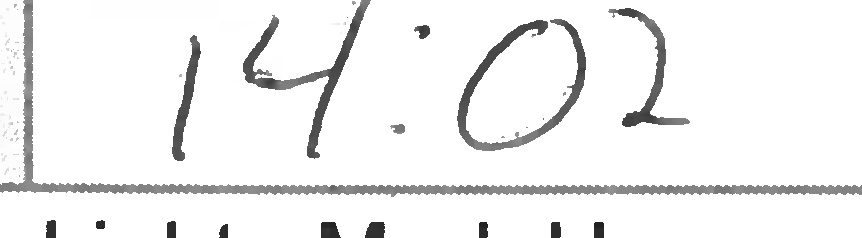

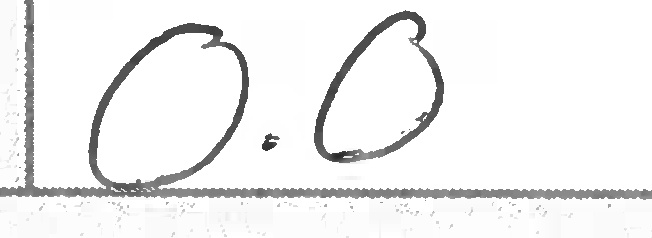

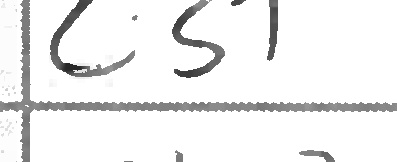

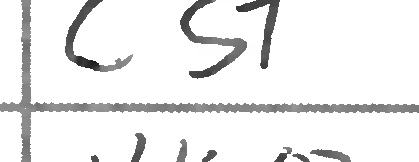

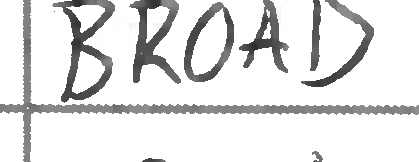

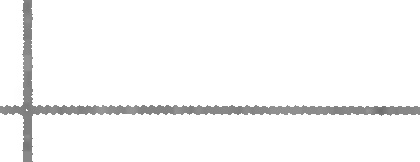

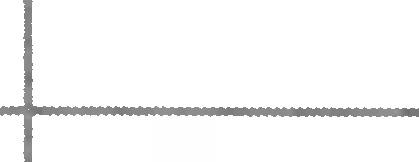

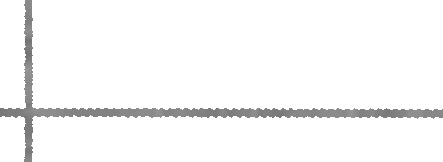

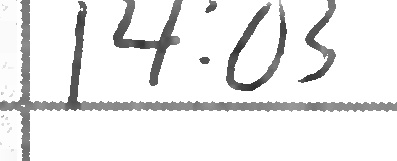

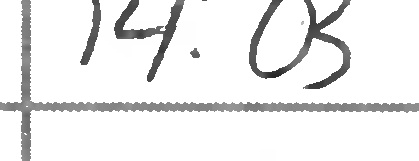

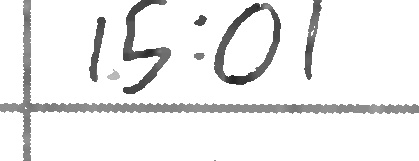

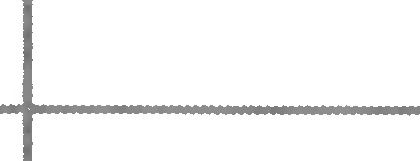

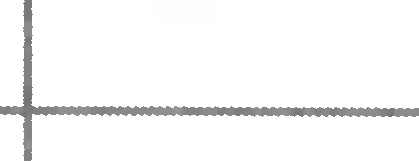

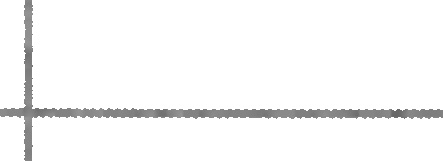

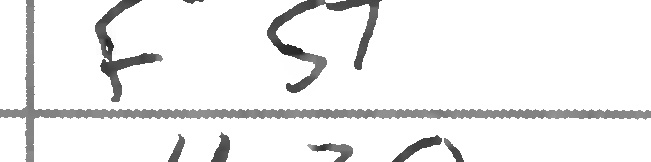

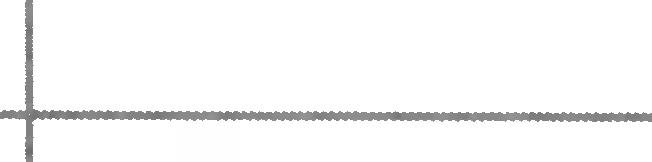

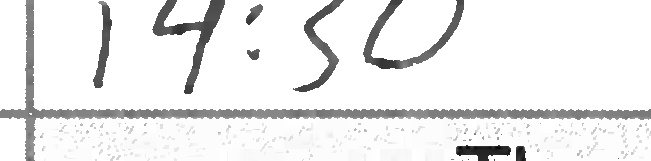

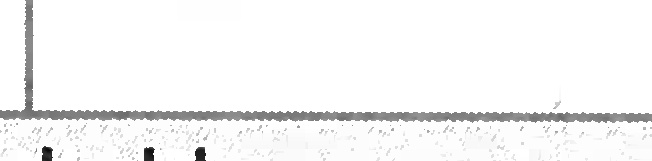

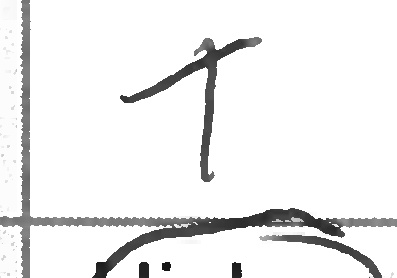

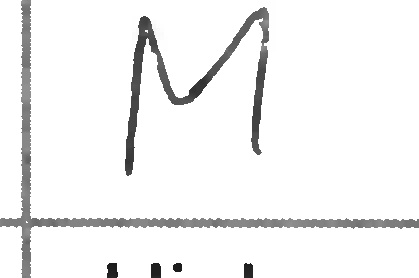

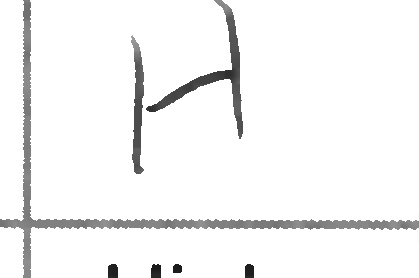

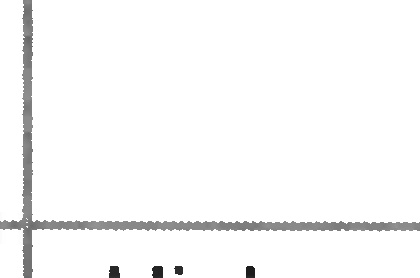

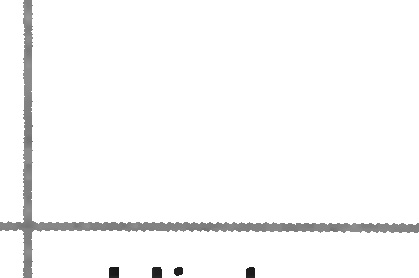

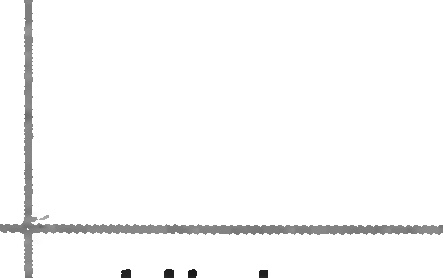

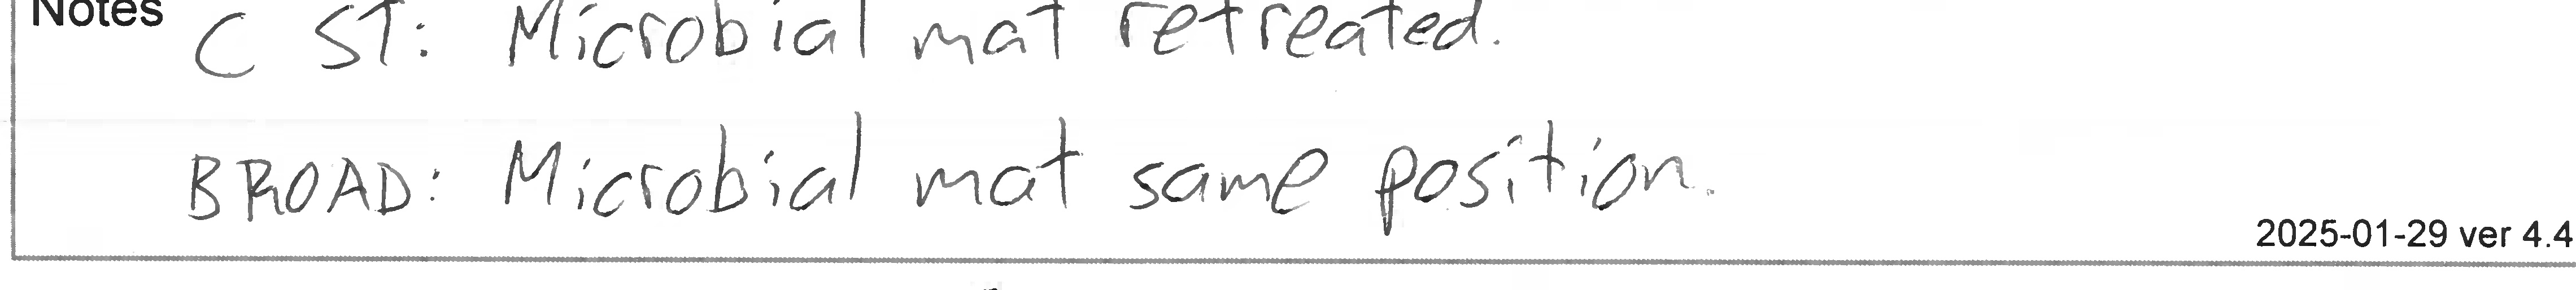

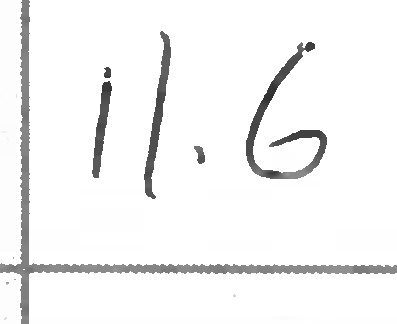

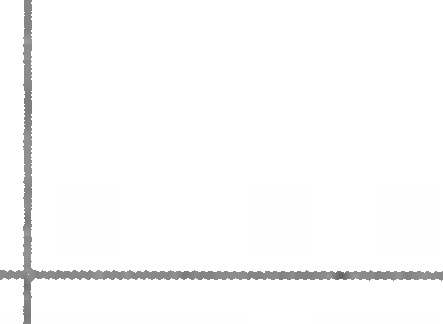

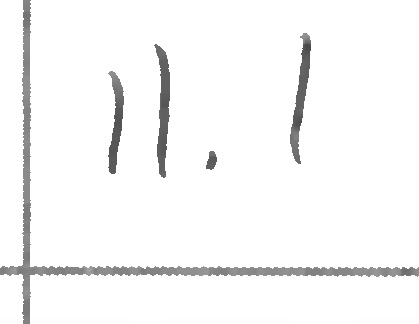

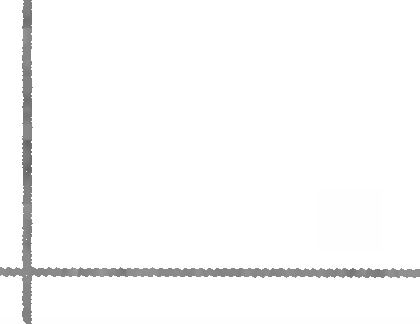

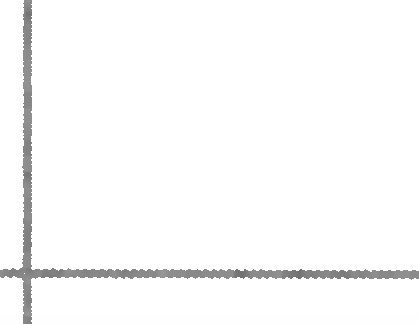

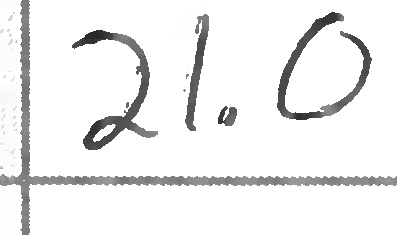

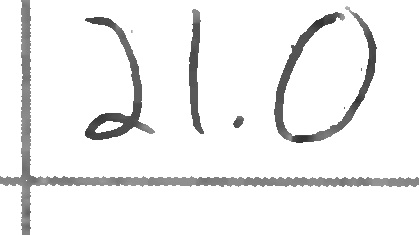

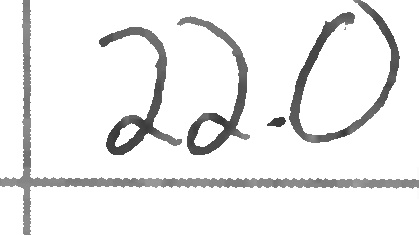

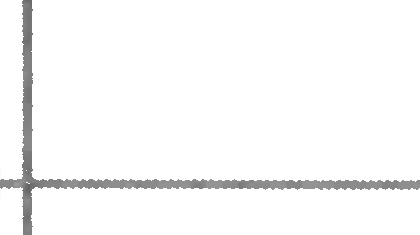

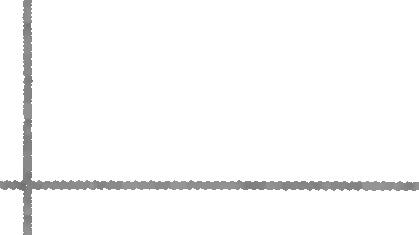

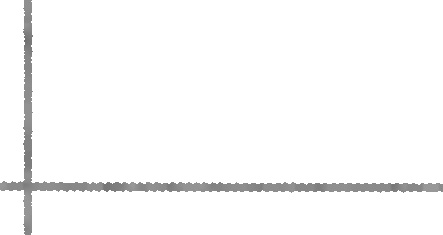

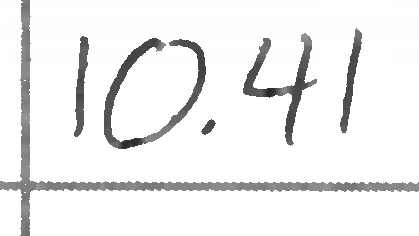

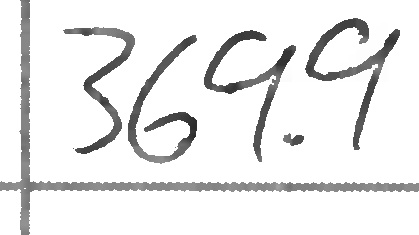

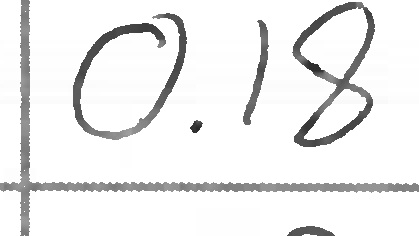

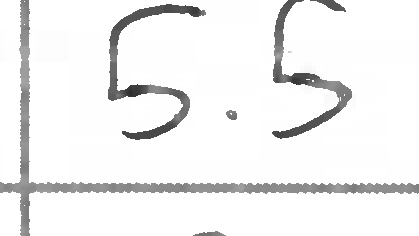

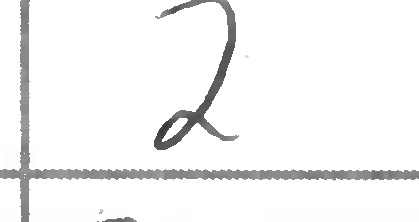

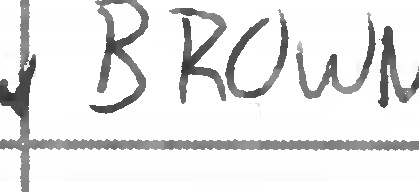

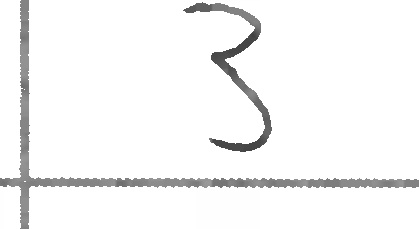

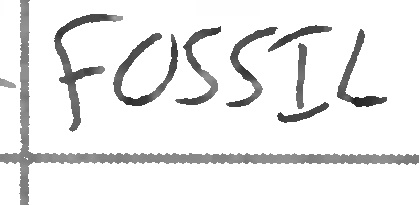

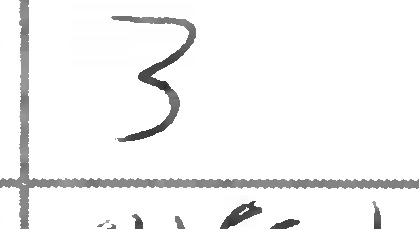

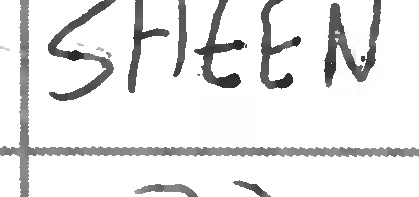

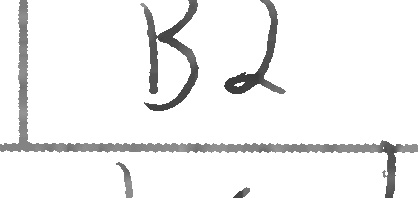

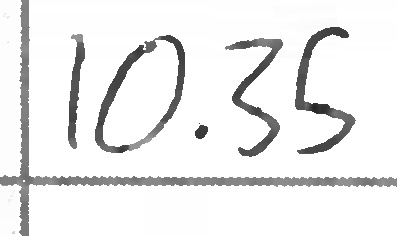

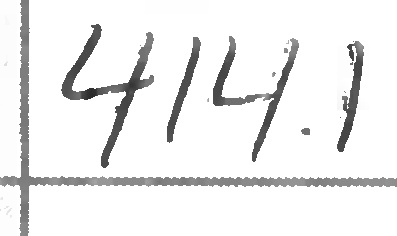

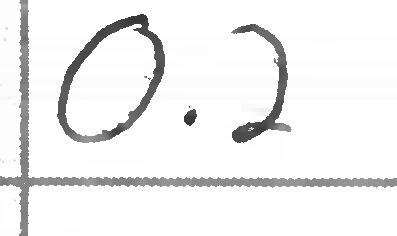

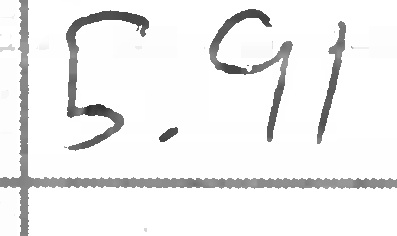

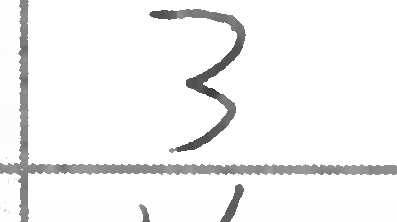

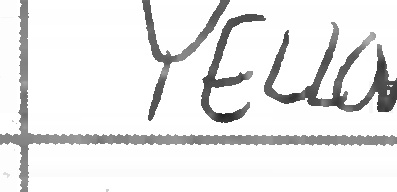

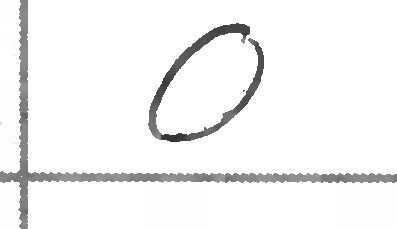

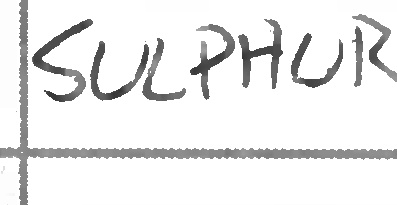

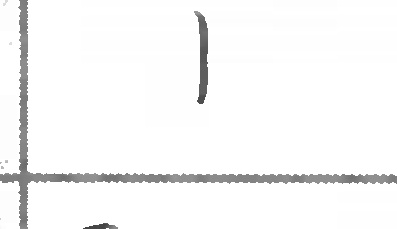

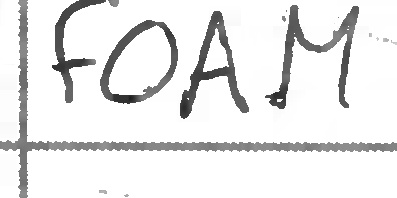

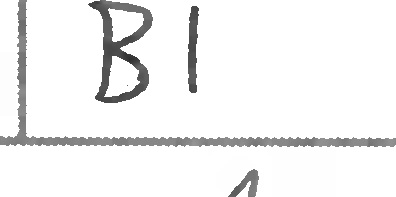

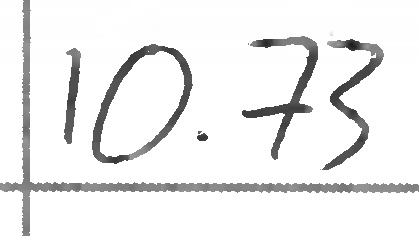

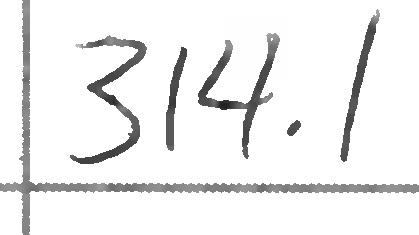

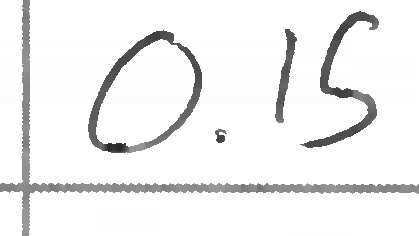

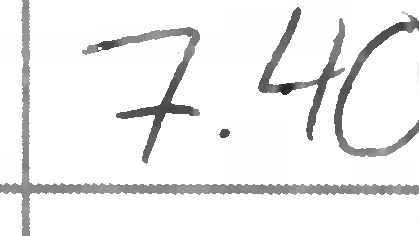

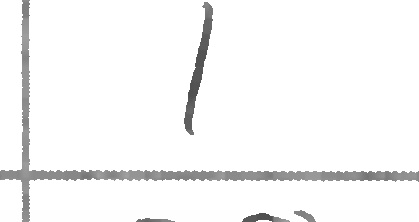

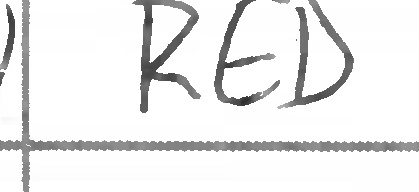

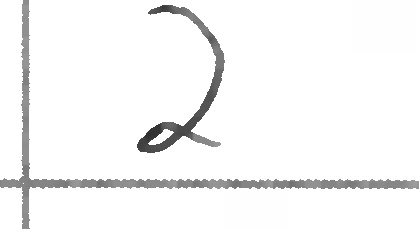

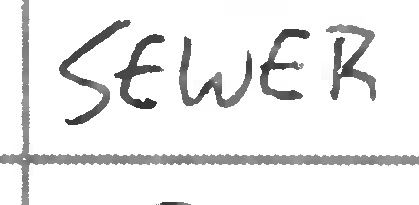

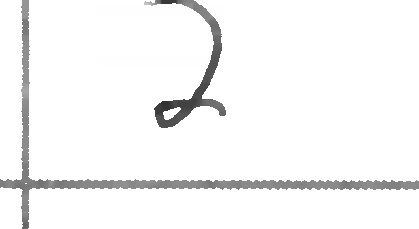

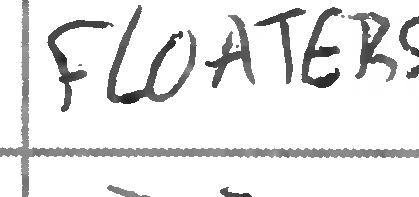

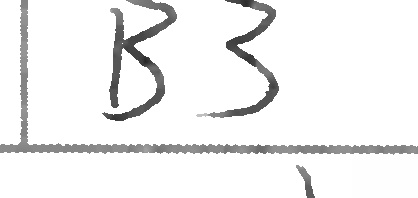

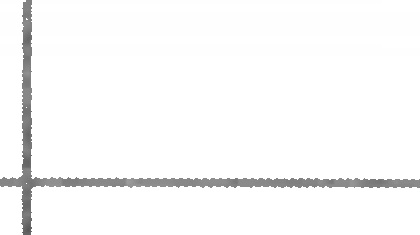

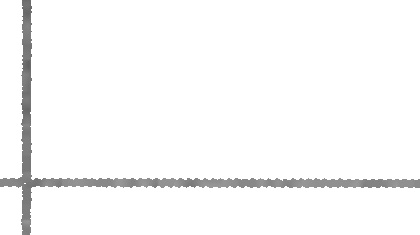

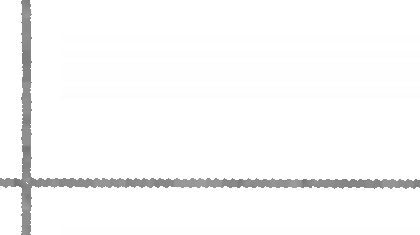

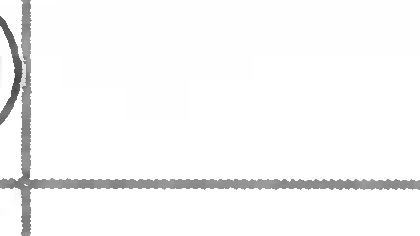

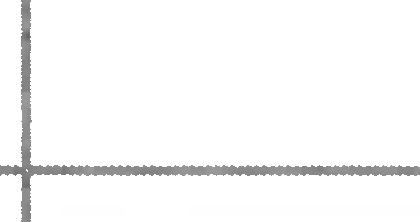

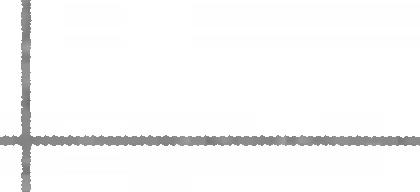

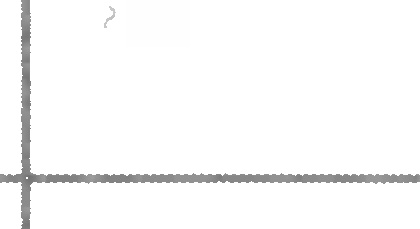

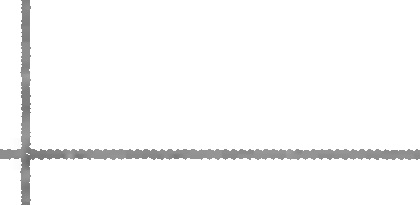

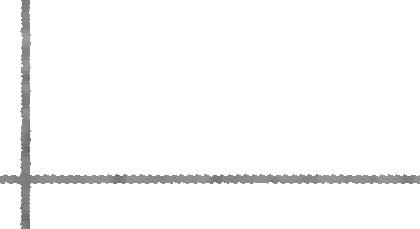

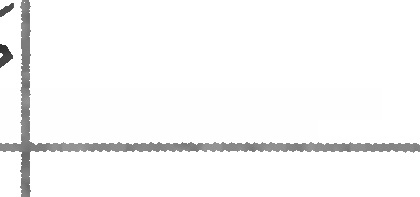

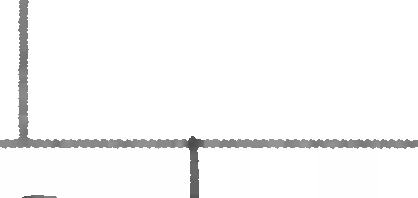

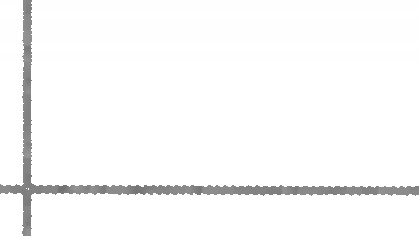

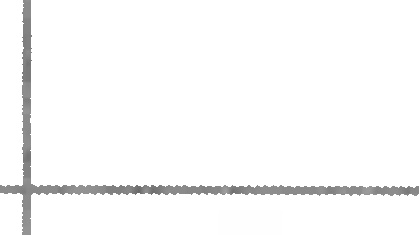

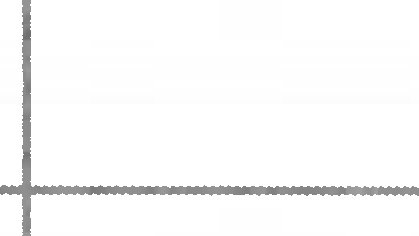

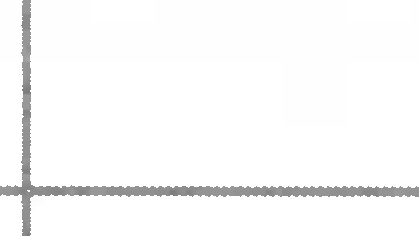

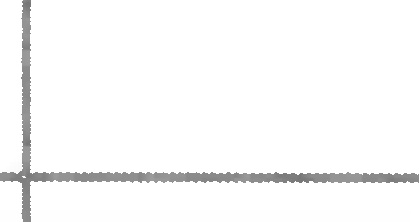

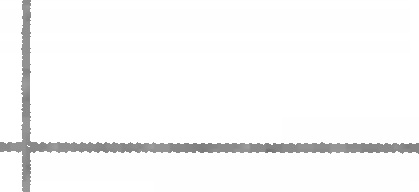

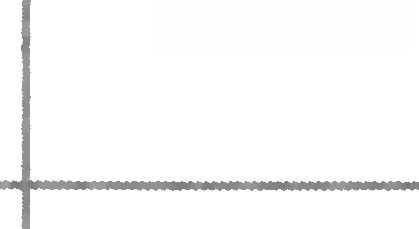

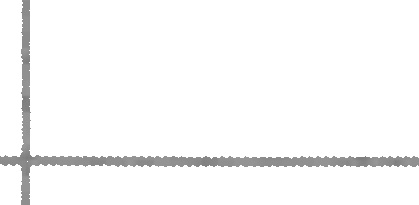

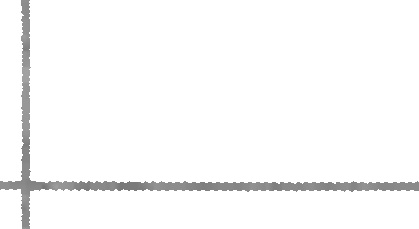

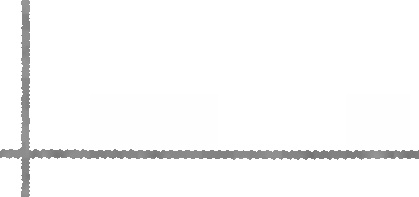

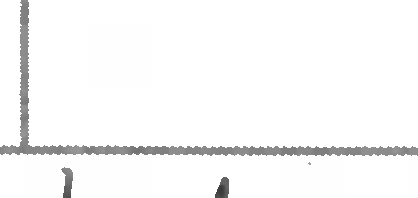

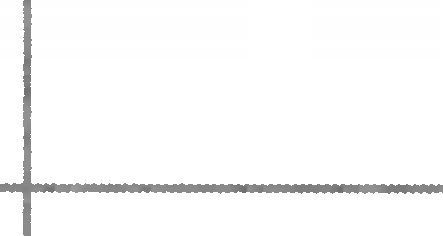

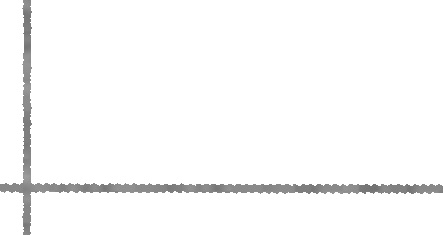

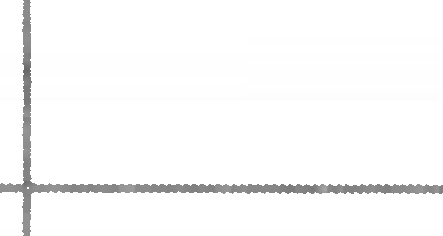

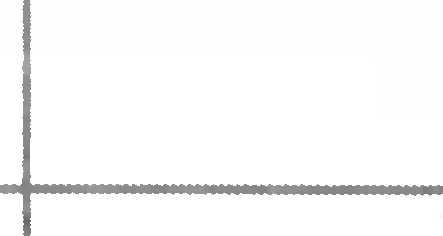

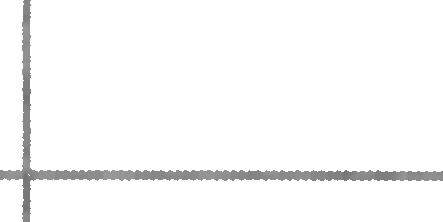

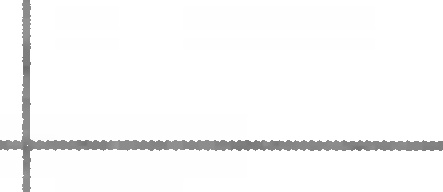

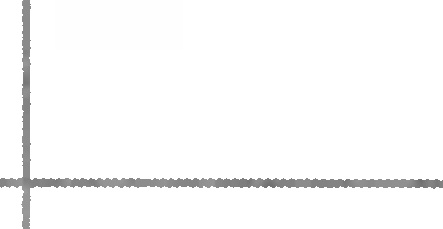

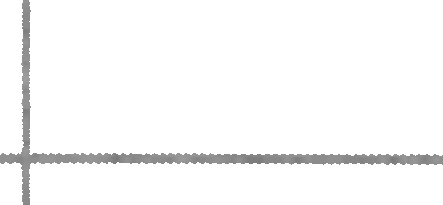

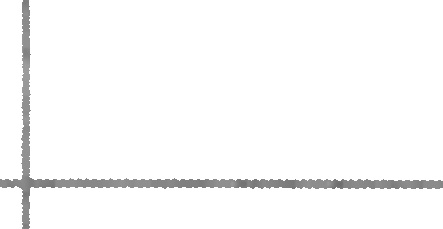

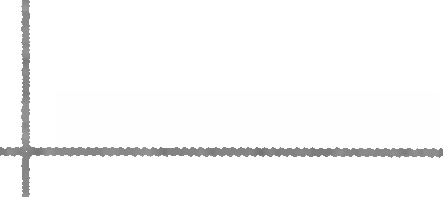

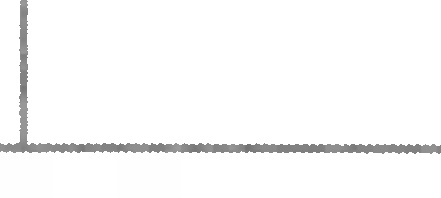

In [ ]:
for roi_field_name, roi_data in ROIs.items():
    roi_img_path = Path(f"scratch/roi_{roi_field_name}.jpg")
    Image(filename=str(roi_img_path), width=200, height=200)


## Apply OCR.

TODO: TBD ... still need to get fiducials in a reliable way that produces accurately bounded ROIs.

In [ ]:
# TODO: Use OCR to extract text from the ROIs.